# **Chap5：注意力机制**

In [56]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import jieba
from source.code import ch5
from source.code import ch4
from source.code import utils

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **5.2 注意力分数**

### **5.2.1 两种注意力计算方法**

在上一节中，我们讨论了如何用高斯核函数来对 `query` 和 `key` 之间的关系建模，并且我们得到了**一般的注意力池化公式**：
$$
\text{AttentionPooling}(x) = \sum_{i=1}^{n_k} \frac{ a(x,x_i)  }{\sum_{j=1}^{n_k} a(x,x_j)} y_i
$$

其中，$a(x,y)\in\mathbb{R}$ **称为注意力分数函数**，或简称**评分函数**，评分函数通过 `Softmax` 变换后转换为一个**概率分布**，即**注意力权重**，最后与 `key` 对应的 `value` 做加权求和，得到注意力输出，如下图所示：

<img src="../source/Chap5/注意力池化思想.svg" width=700>

上一节我们讨论的 `query, key, value` 都是**一维实数**，下面我们讨论更一般的计算过程，并讨论注意力评分函数 $a$ 的设计

假设有一个 `query` $q\in\mathbb{R}^q$，以及 $n_k=n_v=n$ 个 `key-value` 对 $(k_1,v_1),\cdots,(k_{n},v_n)$，其中 $k_i\in\mathbb{R}^{k}, v_i\in\mathbb{R}^v$，注意力汇聚函数 $f$ 可以统一表示为：
$$
f(q,(k_1,v_1),\cdots,(k_n,v_n)) = \sum_{i=1}^{n} w(q,k_i)v_i \in \mathbb{R}^v
$$

其中，`query` $q$ 和 `key` $k_i$ 的**注意力权重（标量）** $w(q,k_i)$ 通过**注意力评分函数** $a(q,k_i):(\mathbb{R}^q,\mathbb{R}^k) \to \mathbb{R}$ **将两个向量映射为标量后**，再经过 `Softmax` 变换得到

$$
w(q,k_i) = \text{Softmax}\left( a(q,k_i) \right) = \frac{ \exp\left(a(q,k_i) \right) }{ \sum_{j=1}^{n} \exp\left(a(q,k_j) \right) } \in\mathbb{R}
$$

因此，**不同的注意力评分函数** $a(q,k)$ **会得到不同的注意力汇聚操作**，我们介绍深度学习中常用的两个评分函数

在此之前，我们需要先介绍**掩蔽Softmax**算子，`Softmax` 操作用于输出一个概率分布作为注意力权重
* 在某些情况下，**并非所有的值都应该被纳入到注意力汇聚中**，例如在上一章的**机器翻译**任务中，为了让每个小批量的序列长度一致，**我们在短序列的末尾填充了无意义特殊词元** `<pad>`
* 为了**仅将有意义的词元作为值来获取注意力汇聚**，可以指定一个有效序列长度 `valid_lens`（有效词元个数），然后**在计算Softmax 时过滤掉超出指定范围的值**

In [3]:
def Masked_Softmax(X : tf.Tensor, valid_lens=None):
    """
    添加掩蔽的 Softmax 操作

    Parameters
    ----------
    X : tf.Tensor
        三维张量，形状为 (batch_size, n_q, n_k)，对应 (batch_size, query 个数, key 个数)
    valid_lens : tf.Tensor
        一维张量或二维张量，形状为 (batch_size, ) 或 (batch_size, n_q)\n
        一维说明批量中的每个 query 样本使用相同的有效长度\n
        二维说明批量中的每个 query 样本使用不同的有效长度\n
    """
    # 不进行掩蔽
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        # 如果 valid_lens 是一维张量，则它只有 batch_size 维度
        # 将其重复 n_q 次，大小变为 (batch_size*n_q,)
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])
        # 如果 valid_lens 是二维张量，将它展开成一维张量
        # 大小变为 (batch_size*n_q,)
        else:
            valid_lens = tf.reshape(valid_lens, shape=(-1,))
        
        # 被掩蔽的元素使用一个非常大的负值 -1e6 替换，从而其 Softmax 输出为 0
        # 可以借用上一章定义的 sequence_mask 函数
        # 先将 X 的形状变成 (batch_size * n_q, n_k)，便于与 valid_lens 操作
        X = utils.sequence_mask(X=tf.reshape(X, shape=(-1, shape[-1])), 
                                valid_len=valid_lens, value=-1e6)

        # 还原回原来的形状，并在最后一轴，即 n_k 所在维度上做 Softmax 操作
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

该函数已经写入 `../source/code/utils.py`，我们来测试下效果

In [5]:
X = tf.random.uniform((2, 2, 5)) # batch_size = 2, query 个数 = 2, key 个数 = 5
valid_lens = tf.constant([2, 3]) # 两组 query 的有效长度分别为 2 和 3
utils.Masked_Softmax(X, valid_lens)

<tf.Tensor: shape=(2, 2, 5), dtype=float32, numpy=
array([[[0.3874024 , 0.61259764, 0.        , 0.        , 0.        ],
        [0.6534972 , 0.34650272, 0.        , 0.        , 0.        ]],

       [[0.49347442, 0.20129122, 0.30523437, 0.        , 0.        ],
        [0.3334698 , 0.37663725, 0.28989294, 0.        , 0.        ]]],
      dtype=float32)>

当然，**同一个样本里的不同** `query` **可以使用不同的** `valid_lens`

In [6]:
X = tf.random.uniform((2, 2, 5)) # batch_size = 2, query 个数 = 2, key 个数 = 4
valid_lens = tf.constant([[2, 3], [1, 4]]) # 两组 query 的有效长度分别为 (2, 3) 和 (2, 4)
utils.Masked_Softmax(X, valid_lens)

<tf.Tensor: shape=(2, 2, 5), dtype=float32, numpy=
array([[[0.5025212 , 0.49747878, 0.        , 0.        , 0.        ],
        [0.303248  , 0.40090445, 0.29584754, 0.        , 0.        ]],

       [[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.14618057, 0.31824294, 0.21065399, 0.3249225 , 0.        ]]],
      dtype=float32)>

**(1) 加性注意力**

一般来说，`query` 和 `key` 是**不同维度的向量**时，可以使用**加性注意力**作为评分函数，给定 `query` $q\in\mathbb{R}^q$，`key` $k_i\in\mathbb{R}^k$，评分函数为：
$$
a(q,k_i) = w_v^T\text{tanh}(W_q q + W_k k_i) \in\mathbb{R}
$$

其中
* 参数 $W_q\in\mathbb{R}^{h\times q}, W_k\in\mathbb{R}^{h\times k}$ 负责**先将** $q,k_i$ **变换到相同的维度** $h$
* $w_v\in\mathbb{R}^h$ 最后**将** $\text{tanh}$ **激活后的** $\mathbb{R}^{h}$ **维向量通过向量内积变为实数**
* $W_q,W_k,w_v$ 都是**模型的可学习参数**，模型**不使用偏置项**

In [7]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, query_size : int, key_size : int, num_hiddens : int, dropout : float, 
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.w_v = tf.keras.layers.Dense(1, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.attn_weights = None
    
    def call(self, queries, keys, values, valid_lens=None, **kwargs):
        # 将 queries 和 keys 变换到 num_hiddens 维度
        # queries 的形状为 (batch_size, n_q, num_hiddens)
        # keys 的形状为 (batch_size, n_k, num_hiddens)
        queries, keys = self.W_q(queries), self.W_k(keys)

        # 利用广播机制，将 queries 和 keys 相加
        # 扩充 queries 维度，变成 (batch_size, n_q, 1, num_hiddens)
        # 扩充 keys 维度，变成 (batch_size, 1, n_k, num_hiddens)
        # features 的形状为 (batch_size, n_q, n_k, num_hiddens)
        features = tf.expand_dims(queries, axis=2) + tf.expand_dims(keys, axis=1)
        features = tf.nn.tanh(features) # 使用 tanh 函数变换

        # 通过 w_v 将输出特征变换为形状为 (batch_size, n_q, n_k, 1) 的张量
        # 去除掉最后多余的维度，形状为 (batch_size, n_q, n_k)
        scores = tf.squeeze(self.w_v(features), axis=-1) # 注意力分数
        self.attn_weights = utils.Masked_Softmax(scores, valid_lens) # 注意力权重
        
        # 计算注意力池化输出，对权重使用 dropout，缓解过拟合
        # (batch_size, n_q, n_k) @ (batch_size, n_v = n_k, v) -> (batch_size, n_q, v)
        Y = self.dropout(self.attn_weights, **kwargs) @ values
        return Y

我们来测试一下上面的**加性注意力层**：
  *  `query` 维度为 `(batch_size = 2, n_q = 1, q = 20)`
  * `key` 维度为 `(batch_size = 2, n_k = 10, k = 2)`
  * `value` 维度为 `(batch_szie = 2, n_v = n_k = 10, v = 4)`

则注意力池化的输出维度应该是 `(batch_size = 2, n_q = 1, v = 4)`

In [8]:
queries = tf.random.normal(shape=(2, 1, 20))
keys = tf.random.normal(shape=(2, 10, 2))
values = tf.reshape(tf.range(80, dtype=tf.float32), shape=(2, 10, 4))
valid_lens = tf.constant([3, 6])

attention = AdditiveAttention(query_size=20, key_size=2, num_hiddens=8, dropout=0.1)
attention(queries, keys, values, valid_lens=valid_lens, training=False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 3.3938313,  4.3938313,  5.3938313,  6.3938313]],

       [[52.387486 , 53.387486 , 54.387486 , 55.387486 ]]], dtype=float32)>

我们可以来看一下**注意力的分布情况**，可以看到超出 `valid_lens` 的部分**全部被遮盖了，注意力权重为 0**

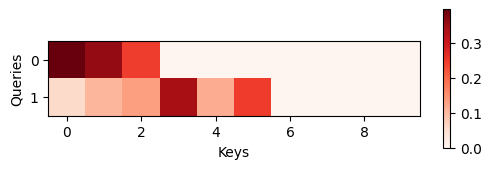

In [9]:
# 注意函数接口，注意力权重需要变换为四维张量
utils.show_attention(tf.reshape(attention.attn_weights, shape=(1, 1, 2, 10)), 
                     xlabel='Keys', ylabel='Queries',figsize=(6, 3))

**(2) 缩放点积注意力**

当 `query` 和 `key` 有相同的维度时，我们可以**借助向量内积更高效的计算注意力分数，并减少模型参数**，设 $q\in\mathbb{R}^d$，$k_i\in\mathbb{R}^d$，则**缩放点积注意力分数**计算为：
$$
a(q,k_i) = \frac{q^Tk_i}{\sqrt{d}}
$$

假设 `query` 和 `key` 的所有元素都是独立的随机变量，并且都满足**零均值和单位方差**，则内积 $q^Tk_i$ 的均值为 0，方差为 $d$，我们除以 $\sqrt{d}$ 来调整进行数据缩放

实践中，我们通常**从批量数据考虑提升计算效率**，现在假设有 $n_q$ 个查询组成的矩阵 $Q\in\mathbb{R}^{n_q\times d}$，$n_k$ 个 `key` 组成的矩阵 $K\in\mathbb{R}^{n_k\times d}$，以及 $n_v = n_k$ 个 `value` 组成的矩阵 $V\in\mathbb{R}^{n_k\times v}$，则缩放点积注意力权重为：
$$
\text{Softmax}\left( \frac{QK^T}{\sqrt{d}} \right)V\in\mathbb{R}^{n_q\times v}
$$

In [10]:
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self, dropout : float, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.attn_weights = None
    
    def call(self, queries, keys, values, valid_lens, *args, **kwargs):
        # queries 的形状为 (batch_size, n_q, d)
        # keys 的形状为 (batch_size, n_k, d)
        # values 的形状为 (batch_size, n_v = n_k, v)
        # valid_lens 的形状为 (batch_size,) 或者 (batch_size, n_q)
        d = queries.shape[-1]
        # 计算注意力分数
        # (batch_size, n_q, d) @ (batch_size, d, n_k) -> (batch_size, n_q, n_k)
        scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(d, dtype=tf.float32))
        self.attn_weights = utils.Masked_Softmax(scores, valid_lens) # 注意力权重

        # 计算注意力池化结果
        # (batch_size, n_q, n_k) @ (batch_size, n_v = n_k, v) -> (batch_size, n_q, v)
        Y = self.dropout(self.attn_weights, **kwargs) @ values
        return Y

我们来测试一下上面的**缩放点积注意力**的计算结果：
  *  `query` 维度为 `(batch_size = 2, n_q = 3, q = d = 10)`
  * `key` 维度为 `(batch_size = 2, n_k = 10, k = d = 10)`
  * `value` 维度为 `(batch_szie = 2, n_v = n_k = 10, v = 4)`

则注意力池化的输出维度应该是 `(batch_size = 2, n_q = 3, v = 4)`

In [11]:
queries = tf.random.normal(shape=(2, 3, 10))
keys = tf.random.normal(shape=(2, 10, 10))
values = tf.reshape(tf.range(80, dtype=tf.float32), shape=(2, 10, 4))
valid_lens = tf.constant([[1, 6, 4], [3, 8, 5]])

attention = DotProductAttention(dropout=0.1)
attention(queries, keys, values, valid_lens=valid_lens, training=False)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 0.       ,  1.       ,  2.       ,  3.       ],
        [10.216486 , 11.216485 , 12.216485 , 13.216485 ],
        [ 6.3999624,  7.3999624,  8.399962 ,  9.399961 ]],

       [[45.037395 , 46.037395 , 47.037395 , 48.037395 ],
        [53.88717  , 54.887173 , 55.88717  , 56.88717  ],
        [46.060684 , 47.06068  , 48.06068  , 49.060684 ]]], dtype=float32)>

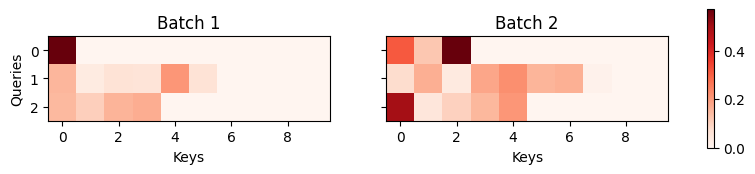

In [12]:
# 注意函数接口，注意力权重需要变换为四维张量
utils.show_attention(tf.reshape(attention.attn_weights, shape=(1, 2, 3, 10)), 
                     xlabel='Keys', ylabel='Queries',figsize=(10, 3),
                     titles=['Batch 1', 'Batch 2'])

### **5.2.2 机器翻译中的 Bahdanau 注意力机制**

我们来看一个注意力机制在机器翻译中的实践

我们在上一章学习了一个基于**两个 RNN 的编码器-解码器架构**用于**序列到序列学习**的机器翻译任务
* 编码器 RNN 将**长度可变的序列**转换为固定形状的**上下文变量** $c$
* 解码器 RNN 根据生成的词元和上下文变量 $c$ 生成下一个词的输出

然而
* **并非所有输入词元（源语句）对解码时某个词元都有帮助**
* 解码器在每个时间步都使用相同的上下文变量 $c$

在预测词元时，如果不是所有输入词元都相关，**模型应该仅关注输入序列中与当前预测相关的部分**，而这可以通过**将上下文变量视为注意力集中的输出来实现**

相较于原始的 RNN 编码器-解码器架构，我们现在来**更新上下文变量** $c$，在解码器预测的每个时间步 $t'$，假设输入序列长度为 $T$ 包含 $T$ 个词元，则解码器 $t'$ 时上下文变量 $c_{t'}$ 是下面注意力池化的输出：
$$
c_{t'} = \sum_{t=1}^{T} w(s_{t'-1}, h_t)h_t
$$

其中，$s_{t'-1}$ 是时间步 $t'-1$ **解码器的隐状态**，它作为 `query`，$h_t$ 是**编码器在编码器每个时间步** $t$ 的**隐状态**，它**同时作为** `key` 和 `value`，注意力分数使用**加性注意力**

下图演示了 Bahdanau 注意力架构示意图：

<img src="../source/Chap5/Bahdanau注意力.svg" width=700>

在实现上，我们只需要**重新定义解码器**，我们可以先定义**注意力解码器的基本接口** `AttentionDecoder`

In [13]:
class AttentionDecoder(utils.Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    # 获取当前解码器的注意力权重
    @property
    def attention_weights(self):
        raise NotImplementedError

`AttentionDecoder` 已经写入 `../source/code/utils.py`

下面我们定义类 `Seq2SeqAttentionDecoder` 以实现带有 Bahdanau 注意力的 RNN 解码器
* 为了**初始化解码器状态**，需要有以下输入：
    * 编码器在**所有时间步** $t=1,\cdots,T$ 的**最后一层隐状态**，它将作为注意力的 `key`, `value`
    * 上一个时间步编码器全层的隐状态，用于**初始化解码器隐状态**
    * **编码器处理输入的有效长度** `valid_len`，这用于排除注意力池化中不必要考虑的词元
* 在每个解码器时间步 $t'$，将上一时间步 $t'-1$ 的最后一层隐状态 $s_{t'-1}$ 作为 `query`
* 最后将注意力池化的输出 $c_{t'}$（**上下文变量**） 和**词元嵌入向量**共同作为解码器的输入

In [8]:
class Seq2SeqAttentionDecoder(utils.AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0,**kwargs):
        super().__init__(**kwargs)
        # 注意力层
        self.attention = ch5.AdditiveAttention(
            query_size=num_hiddens, key_size=num_hiddens, num_hiddens=num_hiddens, dropout=dropout)
        # 词嵌入层
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        # RNN 层
        self.rnn = []
        for i in range(num_layers):
            self.rnn.append(tf.keras.layers.GRU(
                num_hiddens, dropout=dropout, return_sequences=True, return_state=True))
        self.dense = tf.keras.layers.Dense(vocab_size) # 输出层

    def init_state(self, enc_outputs, enc_valid_len=None, *args, **kwargs):
        # 解码器输出 enc_outputs 包含两个元素
        # outputs 形状为 (batch_size, num_steps, num_hiddens)
        # hidden_state 是一个列表，包含 num_layers 个元素
        # 每一层 hidden_state[i] 也是列表
        # 如果是单向 RNN，那么 hidden_state[i] 只包含一个元素，双向 RNN 包含两个元素
        # 每个元素形状 (batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        hidden_state = [tf.concat(layer_state, axis=1) for layer_state in hidden_state]
        
        # 将 valid_len 一起返回，便于注意力掩蔽
        return (outputs, hidden_state, enc_valid_len) 

    def call(self, X, state, **kwargs):
        # 从初始化状态中取出 enc_outputs, hidden_state, enc_valid_len
        enc_outputs, hidden_state, enc_valid_len = state

        # 进行词嵌入
        X = self.embedding(X) # 形状为 (batch_size, num_steps, embed_size)
        X = tf.transpose(X, perm=[1, 0, 2]) # 转置为 (num_steps, batch_size, embed_size)
        outputs, self._attn_weights = [], [] # 注意力输出和注意力权重

        # 依次取出每个时间步
        for x in X:
            # x 的形状为 (batch_size, embed_size)
            # 初始化 query，形状为 (batch_size, n_q = 1, num_hiddens)
            query = tf.expand_dims(hidden_state[-1], axis=1)
            # 利用注意力机制计算上下文变量
            # key, value 的形状为 (batch_size, n_k = n_v = num_steps, num_hiddens)
            # context 的形状为 (batch_size, n_q = 1, num_hiddens)
            # 传入 enc_valid_len 便于注意力掩蔽
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_len, **kwargs)

            # 将上下文和嵌入词特征拼接
            # 拼接后形状为 (batch_size, 1, embed_size + num_hiddens)
            x = tf.concat((context, tf.expand_dims(x, axis=1)), axis=-1)

            # RNN 层计算
            for i,layer in enumerate(self.rnn):
                # 逐层计算时，同时更新隐藏状态
                x, hidden_state[i] = layer(x, hidden_state[i], **kwargs)
            
            # x 形状为 (batch_size, 1, num_hiddens)
            outputs.append(x) # 添加到输出列表中
            self._attn_weights.append(self.attention.attn_weights) # 添加注意力权重

        # 计算输出层
        outputs = tf.concat(outputs, axis=1) # 形状 (batch_size, num_steps, num_hiddens)
        outputs = tf.nn.softmax(self.dense(outputs), axis=-1) # 形状 (batch_size, num_steps, vocab_size)

        return outputs, (enc_outputs, hidden_state, enc_valid_len)

    # 获取注意力权重
    @property
    def attention_weights(self):
        return self._attn_weights

我们沿用上一章中定义的编码器，注意当时我们**在编码器上使用了双向 RNN**
* 这会使得它的**输出**，**隐藏状态的隐藏维度是单向 RNN 的两倍**
* 此时，需要设置解码器的 `num_hiddens` 是**编码器的两倍**

先测试一下编码器-解码器工作是否正确

In [12]:
# 创建编码器-解码器模型
encoder = ch4.Seq2SeqEncoder(vocab_size=10, embed_size=8, 
                             num_hiddens=16, num_layers=2, dropout=0.1)
decoder = ch5.Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, 
                                      num_hiddens=2*16, num_layers=2, dropout=0.1)

# 创建输入
X = tf.zeros((4, 7)) # (batch_size, num_steps)
state = decoder.init_state(encoder(X, training=False), None) # 初始化隐状态
output, state = decoder(X, state, training=False) # 计算输出和更新隐状态
print("输出形状：", output.shape) # (batch_size, num_steps, vocab_size)
print("编码器输出形状：", state[0].shape) # (batch_size, num_steps, 2*num_hiddens)
print("隐藏状态层数：", len(state[1])) # num_layers = 2
print("第一个隐藏状态形状：", state[1][0].shape) # (batch_size, 2*num_hiddens)

输出形状： (4, 7, 10)
编码器输出形状： (4, 7, 32)
隐藏状态层数： 2
第一个隐藏状态形状： (4, 32)


最后，我们在机器翻译任务上实测模型
* 为了**减少模型的训练时间**，我们这里仅设置 `num_steps = 10`

In [3]:
# 创建编码器解码器模型
embed_size, num_hiddens, num_layers, dropout = 32, 64, 2, 0.25
batch_size, num_steps = 1024, 10

# 读取数据
train_iter, src_vocab, tgt_vocab = ch4.load_translation_en_zh(
    file="../source/data/translation/news_v16-en-zh.tsv",
    batch_size=batch_size, num_steps=num_steps)

# 创建编码器-解码器模型
encoder = ch4.Seq2SeqEncoder(vocab_size=len(src_vocab), embed_size=embed_size, 
                             num_hiddens=num_hiddens, num_layers=num_layers, dropout=dropout)
decoder = ch5.Seq2SeqAttentionDecoder(vocab_size=len(tgt_vocab), embed_size=embed_size, 
                                      num_hiddens=2*num_hiddens, num_layers=num_layers, dropout=dropout)
model = utils.EncoderDecoder(encoder, decoder)

  0%|          | 0/322275 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.540 seconds.
Prefix dict has been built successfully.
100%|██████████| 322275/322275 [01:29<00:00, 3590.26it/s]
2023-04-27 16:53:46.451981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 16:53:47.051895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30000 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


平均 472415.7 词元/秒


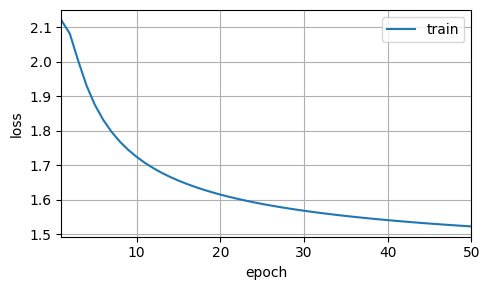

In [4]:
model = utils.train_seq2seq(model, train_iter, tgt_vocab, Epochs=50, lr=0.005)

In [64]:
# model.save_weights("../source/model/ch5_translation_Bahdanau_en_zh.h5")

我们测试模型的预测结果

In [57]:
# 句子对
pairs = [["he says america will not invade others .", "他说，美国不会入侵他国。",],
         ["peace is what we want .", "和平是我们所希望的。",],
         ["cool ! the brother came back !", "酷！大哥归来！",]]
# 保存注意力权重
attention_weights = []
translations = []
# 评估模型
for en, zh in pairs:
    trans, dec_attn_weights = utils.predict_seq2seq(
        model, en, src_vocab, tgt_vocab, num_steps=num_steps, num_preds=10, save_attention_weights=True)
    translations.append(list(jieba.cut(trans)))
    # 变换注意力权重的形状为 (1, 1, num_preds, num_steps)
    dec_attn_weights = tf.reshape(
        tf.concat([step[0][0][0] for step in dec_attn_weights], axis=0), (1, 1, -1, num_steps))
    attention_weights.append(dec_attn_weights)
    # 计算 BLEU
    bleu = utils.chinese_bleu(zh, trans, k=2)
    print(f"{en} \n=> {trans}, bleu {bleu:.3f}")

he says america will not invade others . 
=> 他说，美国不会入侵美国。, bleu 0.759
peace is what we want . 
=> 和平是我们的和平。, bleu 0.615
cool ! the brother came back ! 
=> “大哥”归来！, bleu 0.548


接下来绘制注意力权重的分布，观察**解码器在每个词翻译时，将注意力放置到哪个位置**
* 对于大部分语句的翻译，可以观察到随着翻译词元 $y_{t'}$ 的**时间步从左到右**（$t'=1,\cdots,T'$），**翻译当前词时，模型的注意力也在源文本序列的时间步上从左到右移动**
* 因为提供了 `valid_lens`，模型的**注意力不会被分配到填充词元** `<pad>` 上

In [65]:
from matplotlib import font_manager
font = font_manager.FontProperties(fname="../source/fonts/SimHei.ttf") # 读取中文字体

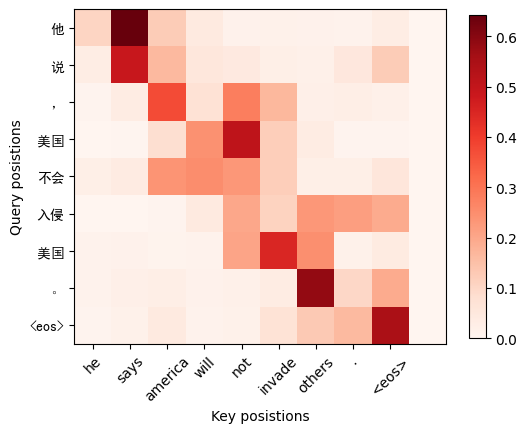

In [79]:
ax = utils.show_attention(attention_weights[0],
                     xlabel='Key posistions', ylabel='Query posistions',figsize=(6, 7))
ax = ax.flatten()
ax[0].set_xticks(range(len(pairs[0][0].split()) + 1))
_ = ax[0].set_xticklabels(pairs[0][0].split() + ["<eos>"], rotation=45)
ax[0].set_yticks(range(len(translations[0]) + 1))
_ = ax[0].set_yticklabels(translations[0] + ["<eos>"],fontproperties=font)

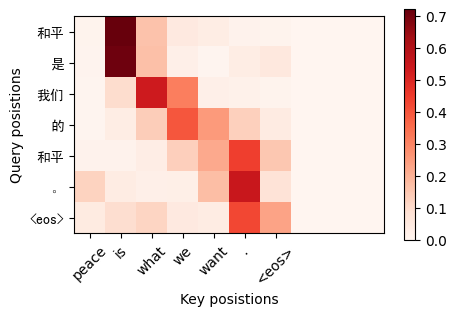

In [75]:
ax = utils.show_attention(attention_weights[1],
                     xlabel='Key posistions', ylabel='Query posistions',figsize=(5, 5))
ax = ax.flatten()
ax[0].set_xticks(range(len(pairs[1][0].split()) + 1))
_ = ax[0].set_xticklabels(pairs[1][0].split() + ["<eos>"], rotation=45)
ax[0].set_yticks(range(len(translations[1]) + 1))
_ = ax[0].set_yticklabels(translations[1] + ["<eos>"],fontproperties=font)

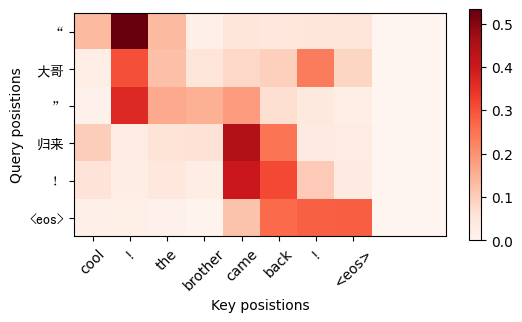

In [76]:
ax = utils.show_attention(attention_weights[2],
                     xlabel='Key posistions', ylabel='Query posistions',figsize=(6, 5))
ax = ax.flatten()
ax[0].set_xticks(range(len(pairs[2][0].split()) + 1))
_ = ax[0].set_xticklabels(pairs[2][0].split() + ["<eos>"], rotation=45)
ax[0].set_yticks(range(len(translations[2]) + 1))
_ = ax[0].set_yticklabels(translations[2] + ["<eos>"],fontproperties=font)

### **5.2.3 多头注意力**

在实践中，当给定相同的 `query`、`key` 和 `value` 集合时。我们希望**模型可以基于相同的注意力机制学习到不同的行为**，最后**再把不同的行为作为知识组合起来**，从而**捕获序列内各种范围的依赖关系**（例如分别捕捉**短距离依赖**和**长距离依赖**）

这类似于 CNN 中，我们希望**同一个位置像素在不同通道上拥有一组而不只是一个特征表达**，因此我们会使用多输入多输出通道的卷积层，不同的卷积核提取不同类型的特征，最后再组合
* 我们希望注意力机制也能有类似的**多通道特点**，允许注意力机制组合使用 `query`、`key` 和 `value` 的**不同子空间表示** 一般是有益的

为此，与其只使用单独一个注意力汇聚，我们可以独立学习得到 $H$ 组不同的注意力汇聚结果，具体地：
* 先用 $H$ 组不同的线性变换将 `query`, `key`, `value` 变换形状
* 将每组变换形状后的 `query`, `key`, `value` 进行**注意力汇聚**操作
* 将 $H$ 组注意力汇聚的输出**在特征维度上拼接在一起**，再通过另一个可以学习的线性变换转换到最终的输出

这种设计称为**多头注意力**（**Multihead Attention**），其框架如下图所示：

<img src="../source/Chap5/多头注意力.svg" width=600>

我们来形式化这个过程，假设 `query` $q\in\mathbb{R}^q$，`key` $k_i\in\mathbb{R}^k$，`value` $v_i\in\mathbb{R}^{v}$，每个**注意力头** $h_j,j=1,2,\cdots,H$ 的计算方式为：
$$
h_j = f(W_j^{(q)}q, W_j^{(k)}k_i, W_j^{(v)}v_i) \in\mathbb{R}^{d_v}
$$

其中，$W_j^{(q)}\in\mathbb{R}^{d_q\times q},W_j^{(k)}\in\mathbb{R}^{d_k\times k},W_j^{(v)}\in\mathbb{R}^{d_v\times v}$ 是可学习参数，$f$ 表示**注意力汇聚函数**，例如上面介绍的**缩放点积注意力**或者**加性注意力**，**多头注意力通过一个线性变换** $W_o\in\mathbb{R}^{o\times H\cdot d_v}$，**将** $H$ **个头拼接后的结果，变换到所需要的维度** $o$：
$$
W_o\left[
\begin{array}{c}
h_1 \\
\vdots\\
h_H
\end{array}
\right] \in\mathbb{R}^{o}
$$

这样，**每个头** $h_i$ **就可以关注输入的不同部分，使整个模型有更强的学习力**

我们下面来实现多头注意力
* 在实现过程中**通常选择缩放点积注意力**作为每一个注意力头，这能避免计算代价和参数代价的大幅增长
* 我们设定 $d_q = d_k = d_v = o / H$
* 实践中，如果将 `query`、`key` 和 `value` 的线性变换的输出数量设置为 $d_pH = d_kH = d_vH = o$，则**可以并行计算** $H$ **个头**，在实现中，输出维度 $o$ 通过参数 `num_hiddens` 指定

In [80]:
def transpose_qkv(X, num_heads):
    """
    对输入进行变换，便于多注意力头的并行计算
    """
    # 输入X的形状 (batch_size, n_q 或 n_k, num_hiddens)
    # 先变换形状为 (batch_size, n_q 或 n_k, num_heads, num_hiddens / num_heads)
    X = tf.reshape(X, shape=(X.shape[0], X.shape[1], num_heads, -1))

    # 交换中间两个轴顺序
    # 变换形状为 (batch_size, num_heads, n_q 或 n_k, num_hiddens / num_heads)
    X = tf.transpose(X, perm=(0, 2, 1, 3))

    # 合并第一第二个轴，形状变为 (batch_size * num_heads, n_q 或 n_k, num_hiddens / num_heads)
    return tf.reshape(X, shape=(-1, X.shape[2], X.shape[3]))

In [81]:
def transpose_output(X, num_heads):
    """
    逆转 transpose_qkv 函数的操作
    """
    # 输入 X 的形状 (batch_size * num_heads, n_q, num_hiddens / num_heads)
    # 先拆分第一第二个轴，形状变为 (batch_size, num_heads, n_q, num_hiddens / num_heads)
    X = tf.reshape(X, shape=(-1, num_heads, X.shape[1], X.shape[2]))
    
    # 交换中间两个轴顺序，形状变为 (batch_size, n_q, num_heads, num_hiddens / num_heads)
    X = tf.transpose(X, perm=(0, 2, 1, 3))

    # 最后合并多头注意力，将最后两个轴合并
    # 输出形状为 (batch_size, n_q, num_hiddens)
    return tf.reshape(X, shape=(X.shape[0], X.shape[1], -1))

In [82]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_heads, dropout, bias=False,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.attention = ch5.DotProductAttention(dropout=dropout)
        # 我们会设定 d_p = d_q = d_v = d_o / h，这样可以并行计算多头注意力
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
        self.W_v = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
        self.W_o = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
    
    def call(self, queries, keys, values, valid_lens=None, *args, **kwargs):
        # queries 形状 (batch_size, n_q, num_hiddens)
        # keys, values 形状 (batch_size, n_k = n_v, num_hiddens)
        # valid_lens 形状 (batch_size,) 或者 (batch_size, n_q)

        # 首先变换 qeuries、keys 和 values 的维度到 num_hiddeans
        # 变换后形状变为 (batch_size * num_heads, n_q 或 n_k, num_hiddens / num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads) 
        keys = transpose_qkv(self.W_k(keys), self.num_heads) 
        values = transpose_qkv(self.W_v(values), self.num_heads) 
        
        # 变换 valid_lens 的形状，用于多头注意力
        if valid_lens is not None:
            # 在轴 0 上重复 num_heads 次
            valid_lens = tf.repeat(valid_lens, repeats=self.num_heads, axis=0)
        
        # 做注意力池化
        # 输出形状为 (batch_size * num_heads, n_q, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens, **kwargs)

        # 最后恢复输出的形状
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat) # 对输出再做一次变换

In [83]:
# 创建多头注意力
num_hiddens, num_heads = 128, 4
attention = MultiHeadAttention(num_hiddens, num_heads, dropout=0.5)
# 输入
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = tf.constant([3, 2])
# 生成 queries, keys, values
queries = tf.ones((batch_size, num_queries, num_hiddens))
keys = tf.ones((batch_size, num_kvpairs, num_hiddens))
values = tf.ones((batch_size, num_kvpairs, num_hiddens))
# 注意力池化
attention(queries, keys, values, valid_lens, training=False).shape

TensorShape([2, 4, 128])

----

### **练习**

1. 在 Bahdanau 注意力实现的机器翻译的例子中，我们来进一步思考：
    1. 你可以尝试对模型进行改动，例如**改变编码器**，将**加性注意力替换为缩短点积注意力**，或者是使用多头注意力等
    2. 尝试训练模型，**模型训练速度缓慢，你无需迭代多次**，仅通过调试确认模型的计算逻辑正确即可
    3. 将加性注意力替换为缩短点积注意力，**对模型有哪些影响**？
    4. 思考，现在**注意力机制只用在了解码器上**，编码器可以加入注意力机制吗？你有什么设想？它能带来什么优势吗？

----